In [461]:
benchmark_dir = '/Users/trex/yarlp_experiments/Mujoco1M_18-11-17-17-29-37_baseline/'
yarlp_dir = '/Users/trex/yarlp_experiments/Mujoco1M/Mujoco1M_2017-11-18_23-45-05/'

In [462]:
import os
import json
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [463]:
# Read in data for yarlp runs


def _merge_stats(experiment_dir):
    """
    Loop through all experiments, and write all the stats
    back to the base repository
    """
    statspath = os.path.join(experiment_dir, 'stats')
    if not os.path.exists(statspath):
        os.makedirs(statspath)
    agg_stats_file = os.path.join(statspath, 'merged_stats.tsv')

    stats_list = []
    for d in os.listdir(experiment_dir):
        base_path = os.path.join(experiment_dir, d)
        if not os.path.isdir(base_path) or d == 'stats':
            continue
        spec = open(os.path.join(base_path, 'spec.json'), 'r')
        spec = json.load(spec)
        
        f = os.path.join(base_path, 'stats.json.txt')
        with open(f, 'r') as f:
            stats = list(map(json.loads, f.readlines()))
        stats = pd.DataFrame(stats) 
        
        stats['param_run'] = spec['param_run']
        stats['run_name'] = spec['run_name']
        stats['agent'] = spec['agent']['type']
        stats['env'] = spec['env']['name']
        stats['agent_params'] = str(spec['agent']['param'])
        stats['seed'] = spec['seed']
        stats_list.append(stats)

    assert len(stats_list) > 0, "No stats were found."
    stats = stats_list[0]
    for s in stats_list[1:]:
        stats = stats.append(s)

    with open(agg_stats_file, 'w') as f:
        stats.to_csv(f, index=False, header=True, sep='\t')
        
    return stats



In [464]:
stats = _merge_stats(yarlp_dir)

training_stats = stats[stats.training == True]

In [465]:
# Read in data for benchmark runs

def _merge_benchmark_stats(experiment_dir):
    statspath = os.path.join(experiment_dir, 'stats')
    if not os.path.exists(statspath):
        os.makedirs(statspath)
    agg_stats_file = os.path.join(statspath, 'merged_stats.tsv')

    stats_list = []
    for d in os.listdir(experiment_dir):
        base_path = os.path.join(experiment_dir, d)
        if not os.path.isdir(base_path) or d == 'stats':
            continue

        stats = pd.read_csv(os.path.join(base_path, 'progress.csv'))

        f = os.path.join(base_path, '0.monitor.csv')
        with open(f, 'r') as f:
            spec = f.readline()
            spec = json.loads(spec[1:])

        stats['env'] = spec['env_id']
        stats['run_name'] = d
        
        stats_list.append(stats)

    assert len(stats_list) > 0, "No stats were found."
    stats = stats_list[0]
    for s in stats_list[1:]:
        stats = stats.append(s)

    with open(agg_stats_file, 'w') as f:
        stats.to_csv(f, index=False, header=True, sep='\t')

    return stats


In [466]:
benchmark_stats = _merge_benchmark_stats(benchmark_dir)

In [ ]:
def plot_data(data, value, time, run, condition, title='', ax=None):
    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)
    sns.set(style="darkgrid", font_scale=1.5)
    plot = sns.tsplot(
        data=data, time=time, value=value, unit=run, condition=condition,
        ax=ax)
#     plot.legend(loc='best')
    plt.title(title)
    return plot

In [468]:

def normalize_timesteps(data, x, by, steps):
    data = data.copy()
    for b in data[by].unique():
        data.loc[data[by] == b, x] = \
            np.arange(0, data[data[by] == b].shape[0] * steps, steps)
    
    return data

def normalize_to_seconds(data, time, by, experiment_name):
    """
    Round seconds and group reward by second for each experiment
    """
    data = data.copy()
    bys = data[by].unique()

    return_data = pd.DataFrame()
    for b in bys:
        d = data.loc[data[by] == b]
        d.loc[:, time] = d[time].apply(lambda x: round(x, 0))
        exp_name = d[experiment_name][0]
        d = d.groupby(time).mean().reset_index()
        d.loc[:, by] = b
        d.loc[:, experiment_name] = exp_name
        d.index = d[time]
        d = d.reindex(index=range(1, int(d[time].max())), method='ffill')
        d[time] = d.index
        return_data = return_data.append(d)

    return return_data


def make_plots(data, env):
    
    figure, axes = plt.subplots(ncols=3, nrows=1, figsize=(3 * 6, 6))
    
    plot1 = plot_data(
        merged_data, 'avg_total_reward', 'episode', 'run_name', 'name', env, axes[0])

    # plot timesteps
    timestep_data = normalize_timesteps(merged_data, 'timesteps_so_far', 'run_name', 1000)
    plot2 = plot_data(
        timestep_data, 'avg_total_reward', 'timesteps_so_far', 'run_name', 'name', env, axes[1])
    
    # plot by seconds
    ts_data = normalize_to_seconds(merged_data, 'time_elapsed', 'run_name', 'name')
    plot3 = plot_data(
        ts_data, 'avg_total_reward', 'time_elapsed', 'run_name', 'name', env, axes[2])
    
    figure.add_subplot(plot1)
    figure.add_subplot(plot2)
    figure.add_subplot(plot3)

    plt.tight_layout()

    return figure


for env in training_stats.env.unique():
    columns = ['avg_total_reward', 'timesteps_so_far', 'run_name', 'env_id']
    benchmark = benchmark_stats[benchmark_stats.env == env].rename(
             columns={'EpRewMean': 'avg_total_reward',
                      'TimestepsSoFar': 'timesteps_so_far',
                      'TimeElapsed': 'time_elapsed',
                      'env': 'env_id'})
    benchmark['name'] = 'benchmark'
    d['episode'] = 0
    for run_name in benchmark.run_name.unique():
        benchmark.loc[benchmark.run_name == run_name, 'episode'] = list(
            range(benchmark[benchmark.run_name == run_name].shape[0]))
    
    yarlp = training_stats[training_stats.env == env]
    yarlp['name'] = 'yarlp'
    merged_data = pd.concat([benchmark, yarlp])
    
    
    fig = make_plots(merged_data, env)


/Users/trex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/trex/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/trex/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

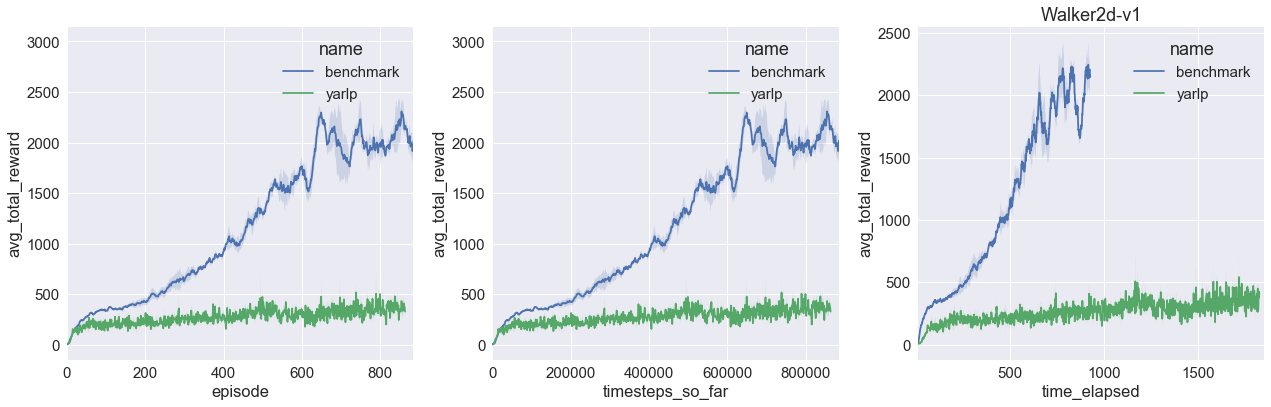

In [469]:
fig

In [441]:
fig.savefig

,time_elapsed,EpLenMean,EpThisIter,EpisodesSoFar,avg_episode_length,avg_reward,avg_total_reward,entloss,entropy,episode,...,optimgain,param_run,seed,std_reward,surrgain,timesteps_so_far,timesteps_this_iter,total_reward,run_name,name
time_elapsed,,,,,,,,,,,,,,,,,,,,,
1,1,19.475,54.0,54.0,NaN,NaN,-0.174649,NaN,8.51365,0.0,...,0.050572,NaN,NaN,NaN,0.050572,0.0,NaN,NaN,Mujoco1M_Walker2d-v1_1,benchmark
2,2,20.025,51.0,105.0,NaN,NaN,1.452754,NaN,8.51365,1.0,...,0.048118,NaN,NaN,NaN,0.048118,1000.0,NaN,NaN,Mujoco1M_Walker2d-v1_1,benchmark
3,3,20.025,51.0,105.0,NaN,NaN,1.452754,NaN,8.51365,1.0,...,0.048118,NaN,NaN,NaN,0.048118,1000.0,NaN,NaN,Mujoco1M_Walker2d-v1_1,benchmark
4,4,21.200,50.0,155.0,NaN,NaN,2.665056,NaN,8.51365,2.0,...,0.059238,NaN,NaN,NaN,0.059238,2000.0,NaN,NaN,Mujoco1M_Walker2d-v1_1,benchmark
5,5,24.700,41.0,196.0,NaN,NaN,4.790366,NaN,8.51365,3.0,...,0.049602,NaN,NaN,NaN,0.049602,3000.0,NaN,NaN,Mujoco1M_Walker2d-v1_1,benchmark
6,6,27.375,37.0,233.0,NaN,NaN,6.347425,NaN,8.51365,4.0,...,0.046414,NaN,NaN,NaN,0.046414,4000.0,NaN,NaN,Mujoco1M_Walker2d-v1_1,benchmark
7,7,30.275,32.0,265.0,NaN,NaN,9.376997,NaN,8.51365,5.0,...,0.048161,NaN,NaN,NaN,0.048161,5000.0,NaN,NaN,Mujoco1M_Walker2d-v1_1,benchmark
8,8,29.975,33.0,298.0,NaN,NaN,9.831508,NaN,8.51365,6.0,...,0.046715,NaN,NaN,NaN,0.046715,6000.0,NaN,NaN,Mujoco1M_Walker2d-v1_1,benchmark
9,9,36.125,24.0,322.0,NaN,NaN,12.721684,NaN,8.51365,7.0,...,0.042935,NaN,NaN,NaN,0.042935,7000.0,NaN,NaN,Mujoco1M_Walker2d-v1_1,benchmark


In [ ]:


# add plotting functions to experiment dir and make them click functions
# add benchmark file to yarlp to remove dependency on baselines

# run benchmark with tensorforce with plots for blog post
# merge and write blog post - compare to paper benchmark on mujoco1m

# do atari on trpo

# do dqn